In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

/scratch/local/5800391/ipykernel_45177/2258313207.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/5800391/ipykernel_45177/2258313207.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/5800391/ipykernel_45177/2258313207.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to 

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_187 = fits.open(f'{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb_i2d.fits')
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_i2d.fits')

# June 30, 2023: switched to realigned-to-refcat version

In [12]:
fh_187 = fits.open(f'{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrcb_realigned-to-refcat_unsatstar.fits')
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_realigned-to-refcat_unsatstar.fits')

In [13]:
ww187 = wcs.WCS(fh_187['SCI'].header)
ww182 = wcs.WCS(fh_182['SCI'].header)

Set OBSGEO-B to   -20.698259 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526844940.057 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.648906 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526264739.299 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [14]:
instrument = fh_187[0].header['INSTRUME']
telescope = fh_187[0].header['TELESCOP']
filt187 = fh_187[0].header['FILTER']
filt182 = fh_182[0].header['FILTER']
instrument, telescope, filt187, filt182

('NIRCAM', 'JWST', 'F187N', 'F182M')

In [15]:
wavelength_table_187 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt187}')
wavelength_table_182 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt182}')

In [16]:
filt187, filt182

('F187N', 'F182M')

In [17]:
waves_182 = wavelength_table_182['Wavelength']
trans_187 = np.interp(waves_182, wavelength_table_187['Wavelength'], wavelength_table_187['Transmission'])
trans_182 = wavelength_table_182['Transmission']

Text(0.5, 0, 'Wavelength [Angstroms]')

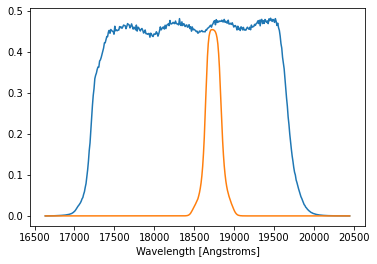

In [18]:
pl.plot(waves_182, trans_182)
pl.plot(waves_182, trans_187)
pl.xlabel("Wavelength [Angstroms]")

In [19]:
fractional_bandwidth_187 = ( (trans_182/trans_182.max()) * (trans_187/trans_187.max()) ).sum() / (trans_182/trans_182.max()).sum()

In [20]:
data_187_proj_182 = reproject.reproject_exact(fh_187['SCI'], fh_182['SCI'].header)

/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [21]:
cont182_sub_paa = (fh_182['SCI'].data - data_187_proj_182[0]*fractional_bandwidth_187)/(1-fractional_bandwidth_187)
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_nrcb.fits', overwrite=True)

In [22]:
paa_minus_cont = data_187_proj_182[0] - cont182_sub_paa #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_nrcb.fits', overwrite=True)

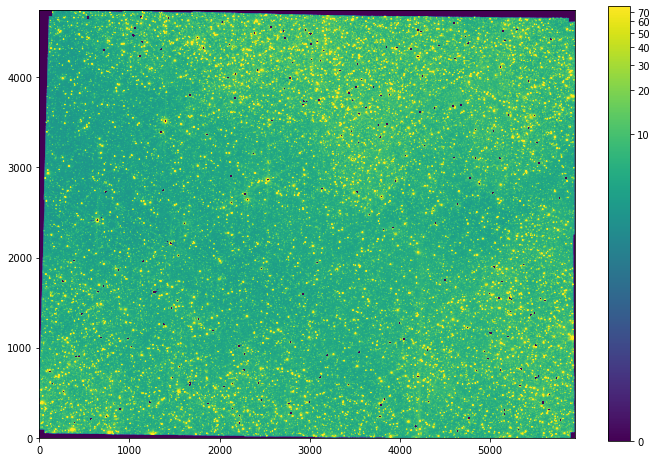

In [23]:
pl.figure(figsize=(12,8))
pl.imshow(fh_182['SCI'].data, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

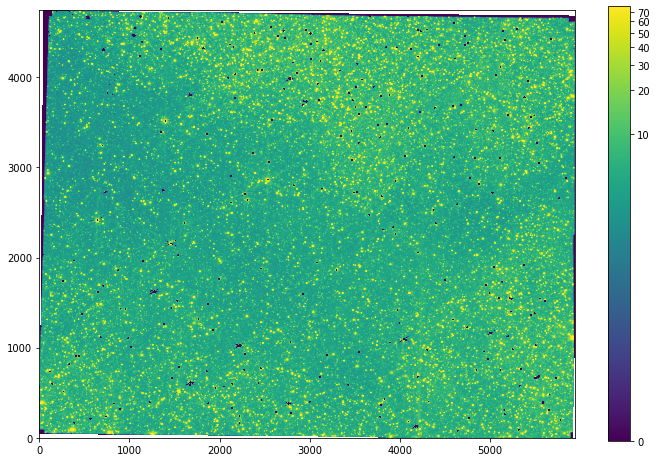

In [24]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

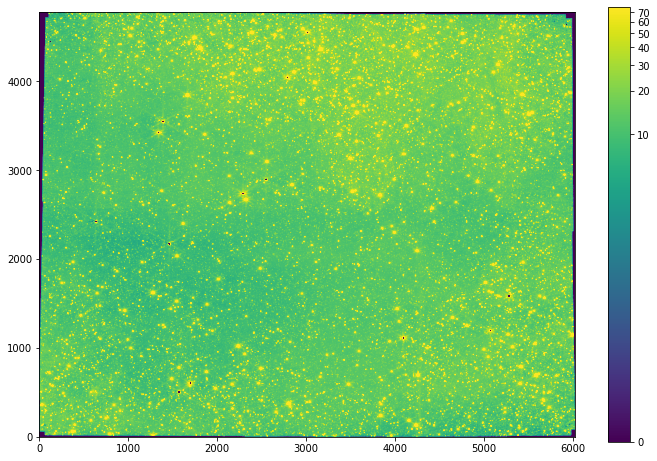

In [25]:
pl.figure(figsize=(12,8))
pl.imshow(fh_187['SCI'].data, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

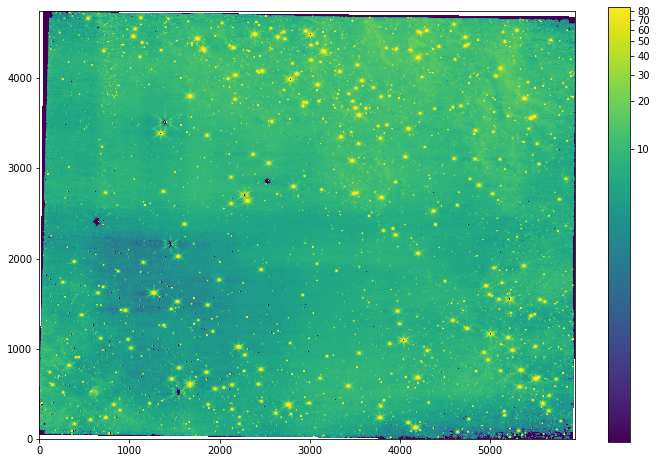

In [26]:
pl.figure(figsize=(12,8))
pl.imshow(paa_minus_cont, norm=simple_norm(paa_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [27]:
stars_paa = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_187['SCI'].data)
stars_paa['skycoord'] = ww187.pixel_to_world(stars_paa['xcentroid'], stars_paa['ycentroid'])
len(stars_paa)

30265

In [28]:
stars_182 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_182['SCI'].data)
stars_182['skycoord'] = ww182.pixel_to_world(stars_182['xcentroid'], stars_182['ycentroid'])
len(stars_182)

130184

In [29]:
matches, sep, _ = stars_paa['skycoord'].match_to_catalog_sky(stars_182['skycoord'], nthneighbor=1)

for cn in stars_paa.colnames:
    stars_paa.rename_column(cn, f"{cn}_187")
for cn in stars_182.colnames:
    stars_182.rename_column(cn, f"{cn}_182")
                         
stars_paa.add_column(name="sep_182_187", col=sep)
stars_paa.add_column(name="id_182_187", col=matches)
mergetbl = table.hstack([stars_paa, stars_182[matches]], join_type='exact')

(array([2.4235e+04, 3.2130e+03, 2.2530e+03, 3.9700e+02, 1.2000e+02,
        3.3000e+01, 8.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([1.48453366e-04, 1.06890554e-01, 2.13632654e-01, 3.20374755e-01,
        4.27116855e-01, 5.33858955e-01, 6.40601056e-01, 7.47343156e-01,
        8.54085256e-01, 9.60827357e-01, 1.06756946e+00]),
 <BarContainer object of 10 artists>)

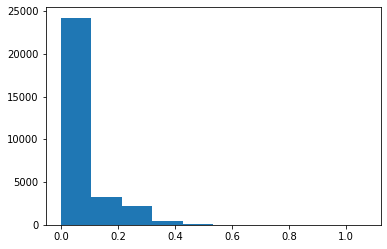

In [30]:
pl.hist(mergetbl['sep_182_187'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

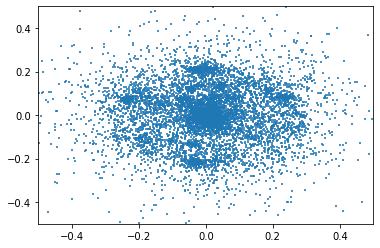

In [31]:
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

# Jan 13, 2023: YIKES:  0.04 x 0.02" major offset!

(-0.05, 0.05, -0.05, 0.05)

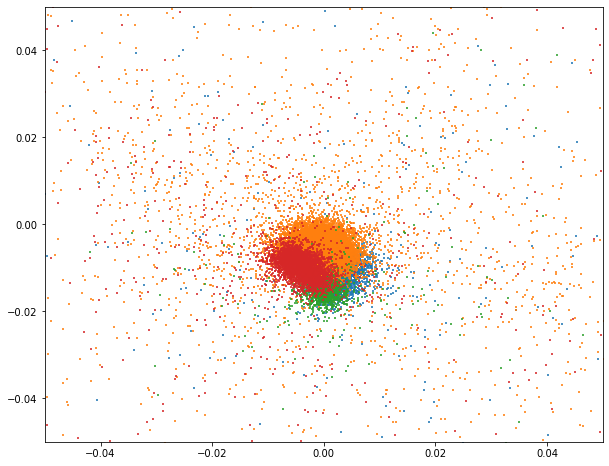

In [32]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])

In [33]:
mergetbl['xcentroid_187'].max(), mergetbl['ycentroid_187'].max()

(6020.449744710403, 4777.285179556392)

In [34]:
dist_from_center = ((mergetbl['xcentroid_187'] - 2950)**2 + (mergetbl['ycentroid_187'] - 2350)**2)**0.5

Text(0, 0.5, 'Offset from F182 (arcseconds)')

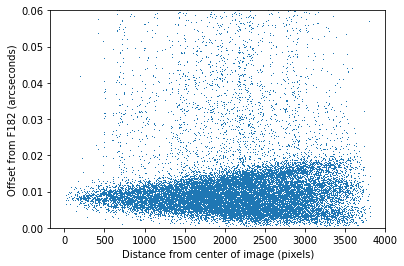

In [35]:
pl.plot(dist_from_center, mergetbl['sep_182_187'].to(u.arcsec).value, ',')
#pl.plot(dist_from_center, dist_from_center/1750 * 0.045 + 0.008)
#pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.06)
pl.xlabel("Distance from center of image (pixels)")
pl.ylabel("Offset from F182 (arcseconds)")

# TODO: replace hand-picked numbers here, which are for F405, not F187

In principle, this should be handled by the pipeline tweakwcs steps, but it's not obvious that that has happened

In [36]:
# selecting 'well-matched' zone (the central blob)
# OLD from other notebook ok = (mergetbl['sep_182_187'] < 0.07*u.arcsec) & (mergetbl['sep_182_187'] < (dist_from_center/1750*0.045 +0.08) *u.arcsec) & (mergetbl['sep_182_187'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)
ok = (mergetbl['sep_182_187'] < 0.07*u.arcsec) & (mergetbl['sep_182_187'] > 0.02*u.arcsec) # good fits do not include zero-offset!

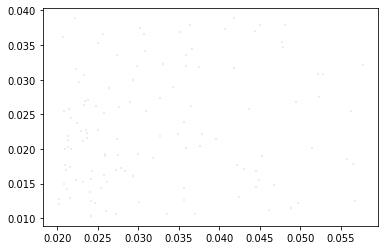

In [37]:
radiff = (mergetbl['skycoord_187'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_187'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
ok = (radiff >0.02*u.arcsec) & (radiff < 0.06*u.arcsec) & (decdiff > 0.01*u.arcsec) & (decdiff < 0.04*u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)

In [38]:
from astropy.wcs.utils import fit_wcs_from_points

Not sure how I chose the SIP degree here.  Investigations of SIP degree are in subsequent cells

In [39]:
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=1)

In [40]:
ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_187'][ok], sip_degree=3)

In [41]:
skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])

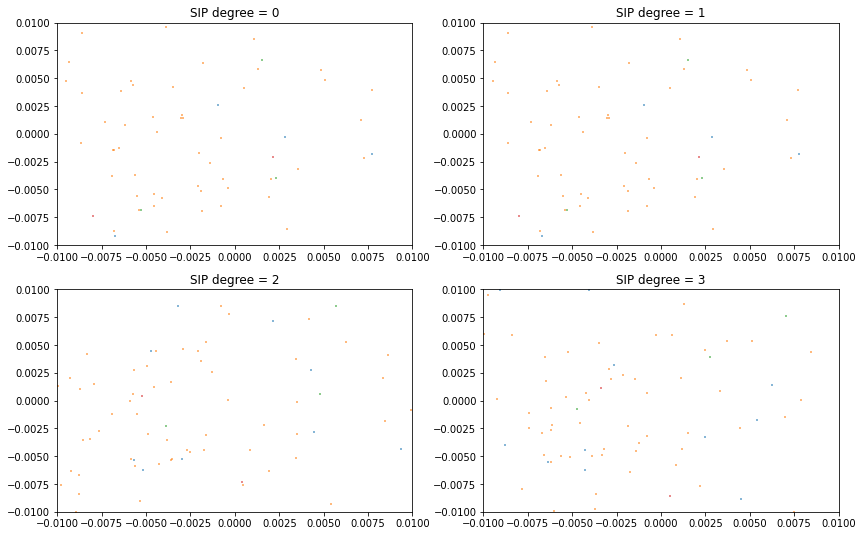

In [42]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    pl.title(f"SIP degree = {sip_degree}")
    
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_187'][ok], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_187'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_187'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_182'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_187'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_187'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_187'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

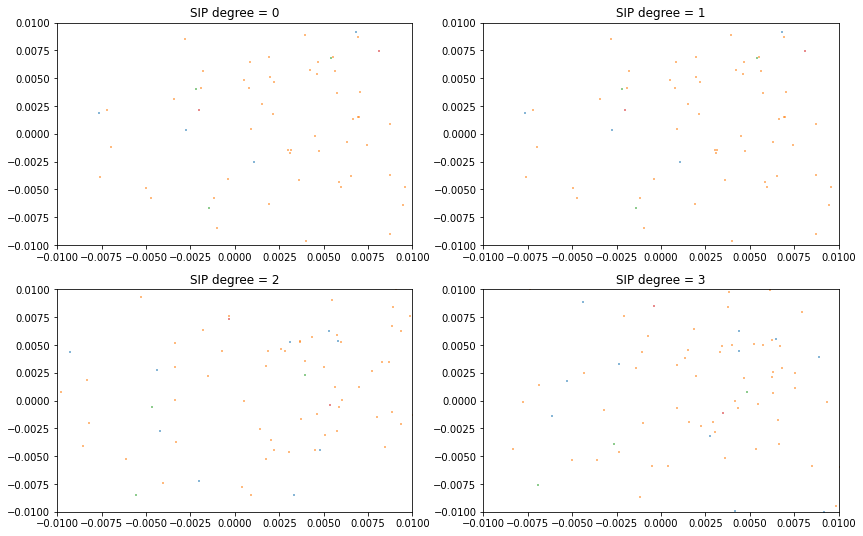

In [43]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    pl.title(f"SIP degree = {sip_degree}")
    
    ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
    skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_187'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_187'] < 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_187'] > 1424) & (mergetbl['ycentroid_187'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [44]:
sip_degree = 3
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok], mergetbl['ycentroid_187'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_187_refit = fit_wcs_from_points([mergetbl['xcentroid_187'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_187'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_187_refit = ww_187_refit.pixel_to_world(mergetbl['xcentroid_187'], mergetbl['ycentroid_187'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_187_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_187_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5


In [45]:
ww_187_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f187n_nrcb_refitted_to_f182m.hdr', overwrite=True)

In [46]:
data_187_proj_182_refit, overlap_refit = reproject.reproject_exact((fh_187['SCI'].data, ww_187_refit), fh_182['SCI'].header)

Set OBSGEO-B to   -20.648906 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526264739.299 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [47]:
fits.PrimaryHDU(data=data_187_proj_182_refit, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_refitted187wcsto182_nrcb.fits', overwrite=True)

In [48]:
cont182_sub_paa = fh_182['SCI'].data - data_187_proj_182_refit*fractional_bandwidth_187
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_refitted187wcsto182_nrcb.fits', overwrite=True)

In [49]:
paa_minus_cont = data_187_proj_182_refit - cont182_sub_paa #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrcb.fits', overwrite=True)

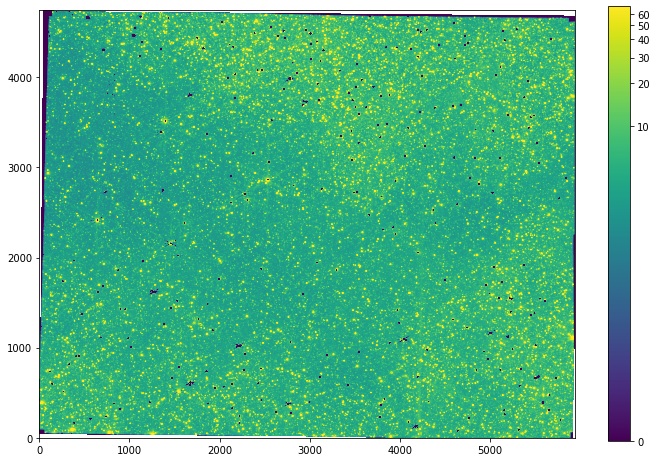

In [50]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

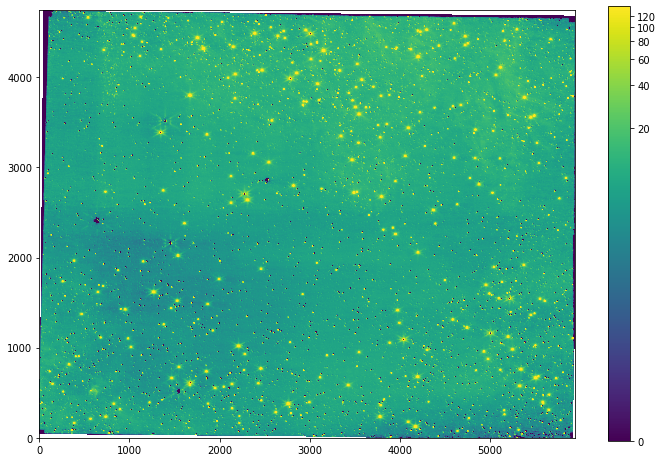

In [51]:
pl.figure(figsize=(12,8))
pl.imshow(paa_minus_cont, norm=simple_norm(paa_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

(0.0, 20.0, 0.0, 100.0)

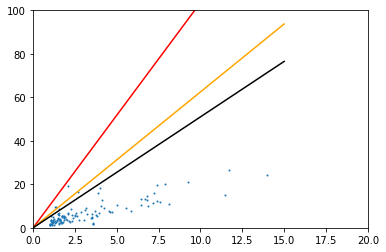

In [52]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_187'][ok], mergetbl['flux_182'][ok], s=1)
pl.plot(xr, xr/fractional_bandwidth_187, color='red')
scalefactor = 0.16
pl.plot(xr, xr/scalefactor, color='orange')
post_destreak_scalefactor = 0.196
pl.plot(xr, xr/post_destreak_scalefactor, color='black')
pl.axis((0,20,0,100))

In [53]:
latest_scalefactor = np.median(1/(mergetbl['flux_182'][ok]/mergetbl['flux_187'][ok]))
latest_scalefactor

0.4746199008630584

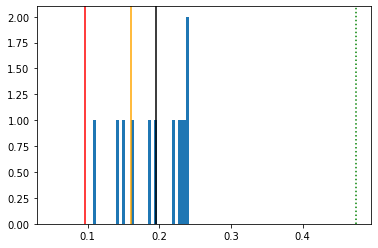

In [54]:
pl.hist(1/(mergetbl['flux_182'][ok]/mergetbl['flux_187'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(post_destreak_scalefactor, color='black')
pl.axvline(fractional_bandwidth_187, color='red')
pl.axvline(latest_scalefactor, color='green', linestyle=':')

In [55]:
cont182_sub_paa = (fh_182['SCI'].data - data_187_proj_182_refit*fractional_bandwidth_187) / (1-fractional_bandwidth_187)
fits.PrimaryHDU(data=cont182_sub_paa, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F182_minus_F187_refitted187wcsto182_nrcb.fits', overwrite=True)

In [56]:
paa_minus_cont = data_187_proj_182_refit - cont182_sub_paa #* fractional_bandwidth_187
fits.PrimaryHDU(data=paa_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrcb.fits', overwrite=True)

In [57]:
print("test")

test
